# Analyze the simulated data

## Simulation on 2K SNPs

In [8]:
import numpy as np
import pandas as pd

import tskit

from tskitetude import get_data_dir

Analyze the `data/sheepTSsimMilano/ts300I2k.vcf.gz` generated using msprime. Get a list of all sample names from VCF file:

```bash
export TSKIT_DIR=${PWD}
cd data/sheepTSsimMilano/
bcftools query -l ts300I2k.vcf.gz > ts300I2k.sample_names.txt
```

Now add population information to the sample names, and then write them into a file:

In [9]:
with open(get_data_dir() / "sheepTSsimMilano" / "ts300I2k.sample_names.txt") as f:
    sample_names = f.read().splitlines()

pop_names = ["MM", "II", "A", "B", "C", "D", "E", "F", "G"]

# create a column for FID
fids = [pop_names[0]] * 5 + [pop_name for pop_name in pop_names[1:] for _ in range(300)]
sample_names = pd.DataFrame({"FID": fids, "IID": sample_names})

sample_names.to_csv(
    get_data_dir() / "sheepTSsimMilano" / "ts300I2k.sample_names_fid.csv",
    sep="\t",
    index=False,
    header=False
)

Analyze the `data/sheepTSsimMilano/ts300I2k.vcf.gz` generated using msprime. Call the `create_tstree` with the following parameters:

```bash
create_tstree --vcf ts300I2k.vcf.gz --focal ts300I2k.sample_names_fid.csv --ancestral_as_reference \
    --output_samples ts300I2k.inferred.samples --output_trees ts300I2k.inferred.trees --num_threads 16 \
    --mutation_rate 5.87e-9 --ne 34500
```

The `5.87-9` and `34500` are the mutation rate and effective population size respectively. The `--ancestral_as_reference` flag is used to treat the ancestral allele as the reference allele. The `--num_threads 4` flag is used to specify the number of threads to use. The `--output_samples` flag is used to specify the output file for the inferred samples. The `--output_trees` flag is used to specify the output file for the inferred trees. 

In [10]:
mutation_rate = 5.87e-9
print("Mutation rate: ", mutation_rate)

Mutation rate:  5.87e-09


In [11]:
ts300I2k = tskit.load(get_data_dir() / "sheepTSsimMilano/ts300I2k.inferred.trees")
ts300I2k

In [12]:
ts300I2k.diversity()

6.2924016481571095e-06

In [13]:
ts300I2k.diversity(mode="branch") * mutation_rate

2.3950493519912347e-06

## Simulation on 25K SNPs

Get sample names (should be equal to previous run):

```bash
bcftools query -l ts300I25k.vcf.gz > ts300I25k.sample_names.txt
```

Now add population information to the sample names, and then write them into a file:

In [14]:
with open(get_data_dir() / "sheepTSsimMilano" / "ts300I25k.sample_names.txt") as f:
    sample_names = f.read().splitlines()

pop_names = ["MM", "II", "A", "B", "C", "D", "E", "F", "G"]

# create a column for FID
fids = [pop_names[0]] * 5 + [pop_name for pop_name in pop_names[1:] for _ in range(300)]
sample_names = pd.DataFrame({"FID": fids, "IID": sample_names})

sample_names.to_csv(
    get_data_dir() / "sheepTSsimMilano" / "ts300I25k.sample_names_fid.csv",
    sep="\t",
    index=False,
    header=False
)

Generate tree:

```bash
create_tstree --vcf ts300I25k.vcf.gz --focal ts300I25k.sample_names_fid.csv --ancestral_as_reference \
    --output_samples ts300I25k.inferred.samples --output_trees ts300I25k.inferred.trees --num_threads 16 \
    --mutation_rate 5.87e-9 --ne 34500
```

In [15]:
ts300I25k = tskit.load(get_data_dir() / "sheepTSsimMilano/ts300I25k.inferred.trees")
ts300I25k

In [16]:
ts300I25k.diversity()

5.04781517762309e-05

In [17]:
ts300I25k.diversity(mode="branch") * mutation_rate

3.753770863863539e-05

## Simulation on entire dataset

Get samples names (like we did before):

```bash
bbcftools query -l tsm100M300I.vcf.gz > tsm100M300I.sample_names.txt
```

Now add population information to the sample names, and then write them into a file:

In [18]:
with open(get_data_dir() / "sheepTSsimMilano" / "tsm100M300I.sample_names.txt") as f:
    sample_names = f.read().splitlines()

pop_names = ["MM", "II", "A", "B", "C", "D", "E", "F", "G"]

# create a column for FID
fids = [pop_names[0]] * 5 + [pop_name for pop_name in pop_names[1:] for _ in range(300)]
sample_names = pd.DataFrame({"FID": fids, "IID": sample_names})

sample_names.to_csv(
    get_data_dir() / "sheepTSsimMilano" / "tsm100M300I.sample_names_fid.csv",
    sep="\t",
    index=False,
    header=False
)

This step will require a lot of time: Submit the job to the cluster:

```bash
cd ${TSKIT_DIR}
sbatch scripts/simulation-tsm100M300I.sh
```

In [19]:
tsm100M300I = tskit.load(get_data_dir() / "sheepTSsimMilano/tsm100M300I.inferred.trees")
tsm100M300I

In [20]:
tsm100M300I.diversity()

0.0008102636799985429

In [21]:
tsm100M300I.diversity(mode="branch") * mutation_rate

0.0007728152520235786

## Calculate FST
define individuals list:

In [22]:
indList = [np.arange(10)] + [np.arange(600*i+10, 600*(i+1)+10) for i in range(8)]

In [23]:
[i.Fst([indList[0], indList[1]], mode="branch") for i in [ts300I2k, ts300I25k, tsm100M300I]]


[0.0038342408825926544, 0.006317426248074964, 0.011025754267375176]

And then with `site` mode:

In [24]:
[i.Fst([indList[0], indList[1]], mode="site") for i in [ts300I2k, ts300I25k, tsm100M300I]]


[0.009344736411834753, 0.011842725047691682, 0.01151736454415031]

In [25]:
tmp = {
    "simulation": ["ts300I2k", "ts300I25k", "tsm100M300I"],
    "diversity": [ts300I2k.diversity(), ts300I25k.diversity(), tsm100M300I.diversity()],
    "diversity_branch": [
        ts300I2k.diversity(mode="branch") * mutation_rate,
        ts300I25k.diversity(mode="branch") * mutation_rate,
        tsm100M300I.diversity(mode="branch") * mutation_rate
    ],
    "FST_branch": [i.Fst([indList[0], indList[1]], mode="branch") for i in [ts300I2k, ts300I25k, tsm100M300I]],
    "FST_site": [i.Fst([indList[0], indList[1]], mode="site") for i in [ts300I2k, ts300I25k, tsm100M300I]]
}
pd.DataFrame(tmp)

,simulation,diversity,diversity_branch,FST_branch,FST_site
0,ts300I2k,0.000006,0.000002,0.003834,0.009345
1,ts300I25k,0.000050,0.000038,0.006317,0.011843
2,tsm100M300I,0.000810,0.000773,0.011026,0.011517


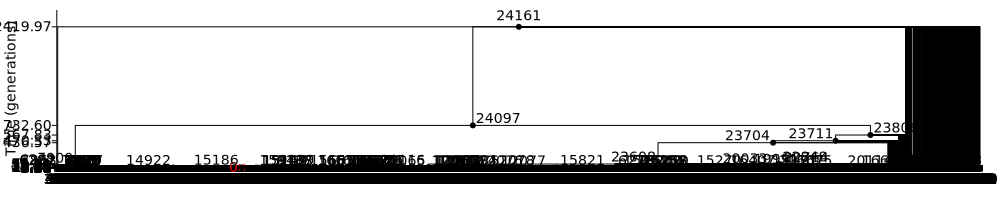

In [26]:
tree = ts300I2k.at_index(1)
tree.draw_svg(y_axis=True, size=(1000, 200))

In [27]:
tree.root

24161

Print the age of the tree:

In [28]:
tree.time(tree.root)

2419.970456028269

Iterate over the trees and get time (throw away the 0 time nodes):

In [29]:
for u in tree.nodes():
    if tree.time(u) > 0:
        print(f"Node {u}: time {tree.time(u)}")

Node 24161: time 2419.970456028269
Node 6272: time 7.597600273671201
Node 6291: time 26.31770313872415
Node 6282: time 7.133026944497379
Node 8130: time 30.808640727829616
Node 9098: time 5.919143896103064
Node 14896: time 5.058889371195002
Node 14898: time 4.941485464703595
Node 14899: time 5.0597982868446625
Node 14900: time 5.0597982868446625
Node 14901: time 4.781067506821409
Node 14903: time 4.941485464703595
Node 14907: time 5.044889539105368
Node 21767: time 22.301401917063124
Node 6623: time 17.079190882279274
Node 23284: time 9.271694187439229
Node 23513: time 34.319173533927874
Node 23703: time 12.49411467088767
Node 24097: time 732.5986509374583
Node 7900: time 52.37935746803915
Node 6280: time 7.70544055191454
Node 7863: time 10.938434913398243
Node 7865: time 10.377948118381997
Node 7867: time 10.7159733312213
Node 7869: time 10.922764701031726
Node 7870: time 10.201473664860668
Node 7871: time 10.471481082491223
Node 7872: time 4.913621274239592
Node 7881: time 6.50758110